# Extended figure 8a: comparison with bladder tumors for sex bias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append('../..') 
sys.path.append("../../main/Fig3")
from plot_f3 import *
from consensus_variables import * 

In [3]:
pd. set_option('display.max_columns', None)

In [4]:
bladder_panel_sex = [
                # 'KMT2D',
                'ARID1A','KDM6A','RBM10',
                 # 'EP300',
                'STAG2',
                # 'CREBBP','NOTCH2',
                 # 'FOXQ1',
                 'CDKN1A',
                # 'KMT2C',
                'TP53',
                 # 'RB1','FGFR3',
                 # 'PIK3CA',
                 # 'TERT'
                ]
sex_genes = ["RBM10_truncating", "CDKN1A_truncating", 
             "ARID1A_truncating", "STAG2_truncating",
             "KDM6A_truncating", "KDM6A_missense", "TP53_missense"]

### Fig 8a part 1: proportion of mutated tumors per gene

In [5]:
# load mut counts results
mut_tumors_df_count = pd.read_csv("../../data/tumors/genie/mutated_tumors_bysex_counts.tsv",
              sep = "\t")
mut_tumors_df_count

,gene,impact,Sex,mut_status_str,count,total,percentage
0,ARID1A,missense,F,MUT,46,700,6.571429
1,ARID1A,missense,F,WT,654,700,93.428571
2,ARID1A,missense,M,MUT,162,2265,7.152318
3,ARID1A,missense,M,WT,2103,2265,92.847682
4,ARID1A,truncating,F,MUT,123,700,17.571429
...,...,...,...,...,...,...,...
107,TP53,missense,M,WT,1499,2265,66.181015
108,TP53,truncating,F,MUT,96,700,13.714286
109,TP53,truncating,F,WT,604,700,86.285714
110,TP53,truncating,M,MUT,318,2265,14.039735


In [6]:
mut_tumors_df_count["gene_extended"] = mut_tumors_df_count["gene"] + "_" + mut_tumors_df_count["impact"]
mut_tumors_df_count = mut_tumors_df_count.drop(["gene", "impact"], axis = 1)
mut_tumors_df_count = mut_tumors_df_count.rename({"gene_extended": "gene"}, axis = 1)
mut_tumors_df_count

,Sex,mut_status_str,count,total,percentage,gene
0,F,MUT,46,700,6.571429,ARID1A_missense
1,F,WT,654,700,93.428571,ARID1A_missense
2,M,MUT,162,2265,7.152318,ARID1A_missense
3,M,WT,2103,2265,92.847682,ARID1A_missense
4,F,MUT,123,700,17.571429,ARID1A_truncating
...,...,...,...,...,...,...
107,M,WT,1499,2265,66.181015,TP53_missense
108,F,MUT,96,700,13.714286,TP53_truncating
109,F,WT,604,700,86.285714,TP53_truncating
110,M,MUT,318,2265,14.039735,TP53_truncating


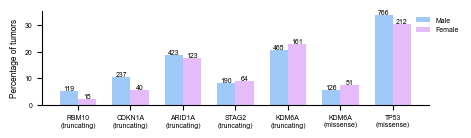

In [7]:
# plot
sex_genes_names = []
for g in sex_genes:
    g = g.split("_")
    sex_genes_names.append(f"{g[0]}\n({g[1]})")
    
    
df_subset = mut_tumors_df_count.loc[mut_tumors_df_count['gene'].isin(sex_genes)]

# Group and pivot
pivot_count_df = df_subset.pivot_table(index=['gene', 'Sex'], columns='mut_status_str', values='count').reset_index()
pivot_count_df = pivot_count_df.rename({"WT": "WT_count", "MUT": "MUT_count"}, axis = 1)
pivot_percent_df = df_subset.pivot_table(index=['gene', 'Sex'], columns='mut_status_str', values='percentage').reset_index()
pivot_percent_df = pivot_percent_df.rename({"WT": "WT_percent", "MUT": "MUT_percent"}, axis = 1)
pivot_df = pivot_count_df.merge(pivot_percent_df, on = ["gene", "Sex"])

# Ensure consistent order
pivot_df['Sex'] = pd.Categorical(pivot_df['Sex'], categories=['M', 'F'], ordered=True)
pivot_df = pivot_df.sort_values(['gene', 'Sex'])

# Setup for side-by-side bars
genes = sex_genes
x = np.arange(len(genes))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(4.991, 1.497))

for i, gene in enumerate(genes):
    for sex in ['M', 'F']:
        row = pivot_df.loc[(pivot_df['gene'] == gene) & (pivot_df['Sex'] == sex)]
        if not row.empty:
            wt = row.get('WT_count', pd.Series([0])).values[0]
            mut = row.get('MUT_count', pd.Series([0])).values[0]
            wt_percent = row.get('WT_percent', pd.Series([0.0])).values[0]
            mut_percent = row.get('MUT_percent', pd.Series([0.0])).values[0]

            xpos = i - bar_width/2 if sex == 'M' else i + bar_width/2
            color = clinvar2color["SEX"][sex]

            sex_label = "Male" if sex == 'M' else "Female"
            ax.bar(xpos, mut_percent,
                width=bar_width, color=color,
                label=sex_label if i == 0 else "")
            ax.text(xpos, mut_percent+1,
                    f"{int(mut):,}", ha='center', va='center',
                    fontsize=plots_general_config["annots_fontsize"])

# X-axis labels centered between bars
ax.set_xticks(x)
ax.set_xticklabels(sex_genes_names, fontsize = plots_general_config["xyticks_fontsize"])

# ax.set_ylim(0, 100)
ax.set_ylabel('Percentage of tumors', fontsize = plots_general_config["xylabel_fontsize"])
ax.tick_params(axis = "y", labelsize = plots_general_config["xyticks_fontsize"])
ax.legend(bbox_to_anchor=(0.96, 0.96), loc='upper left', borderaxespad=0., frameon=False, 
        fontsize = plots_general_config["legend_fontsize"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.subplots_adjust(bottom=0.25)
plt.savefig(f"plot/ExtendedFig8.genie-sex.pdf", dpi = 300)
plt.show()

### Fig 8a part 2: logistic regression

In [8]:
# load regression results
regr_df = pd.read_csv("../../data/tumors/genie/regressions/mutated_tumors_sex_logit_res.tsv",
              sep = "\t")
regr_df

,gene,coeff,lowci,highci,qval
0,ARID1A_missense,1.095206,0.780312,1.537173,0.866383
1,ARID1A_truncating,1.077262,0.863240,1.344347,0.866383
2,CDKN1A_missense,1.553812,0.687114,3.513729,0.740186
3,CREBBP_missense,0.767435,0.539428,1.091816,0.564510
4,CREBBP_truncating,1.118005,0.791481,1.579236,0.866383
5,EP300_missense,1.088221,0.780320,1.517615,0.866383
6,EP300_truncating,1.076577,0.727976,1.592113,0.866383
7,FGFR3_missense,0.771452,0.625852,0.950925,0.140344
8,FGFR3_truncating,1.133836,0.315430,4.075651,0.900024
9,KDM6A_missense,0.749608,0.535186,1.049938,0.462741


In [9]:
regr_df_selection = regr_df.loc[regr_df["gene"].isin(sex_genes)].copy()
regr_df_selection["gene"] = regr_df_selection["gene"].apply(lambda x: f'{x.split("_")[0]} ({x.split("_")[1]})')
regr_df_selection

,gene,coeff,lowci,highci,qval
1,ARID1A (truncating),1.077262,0.863240,1.344347,0.866383
9,KDM6A (missense),0.749608,0.535186,1.049938,0.462741
10,KDM6A (truncating),0.864855,0.705661,1.059962,0.566449
23,STAG2 (truncating),0.909940,0.676213,1.224453,0.866383
24,TP53 (missense),1.176281,0.979354,1.412806,0.462741
26,CDKN1A (truncating),1.943249,1.373487,2.749365,0.000701
27,RBM10 (truncating),2.463063,1.428781,4.246054,0.002356


In [10]:
sex_genes_names = []
for g in sex_genes:
    sex_genes_names.append(f'{g.split("_")[0]} ({g.split("_")[1]})')
sex_genes_names

['RBM10 (truncating)',
 'CDKN1A (truncating)',
 'ARID1A (truncating)',
 'STAG2 (truncating)',
 'KDM6A (truncating)',
 'KDM6A (missense)',
 'TP53 (missense)']

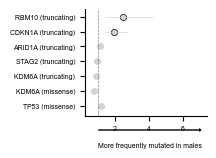

In [11]:
plots_general_config_v = plots_general_config
plots_general_config_v["dot_size_coeffplot"] = 20
plot_config = {"title": "",
                "ylabels_gene_xcoord": -0.65,
                "arrow_xlim": 6,
                "arrow_yloc": -1.65,
                "arrow_head_width": 0.2,
                "arrow_head_length": 0.1,
                "effectsize_text": "More frequently mutated in males",
                "effectsize_text_loc": 1,
                "effectsize_text_yloc": -2.8,
                "sign_threshold": 0.05,
                "null_effect": 1
                }
regr_res_coeffplot(regrres_df = regr_df_selection, 
                   plot_config = plot_config,
                   plots_general_config = plots_general_config,
                   responses = sex_genes_names[::-1], 
                   save_file = "plot/ExtendedFig8.genie-sex-regr.pdf",
                   regrres2compare_df = None,
                   figsize = (1.572, 1.383), remove_ylabels = False, 
                   add_arrow = True)